<a href="https://colab.research.google.com/github/rzagni/itesm-aiml/blob/main/Deep%20Learning/A4_DL_TC5033_Transformer-2_Team56.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Advanced Machine Learning Methods**
###**Tecnológico de Monterrey**
###**Prof José Antonio Cantoral Ceballos**

###**Word Embeddings**
###**Activity 4: Implementing a Translator**

#### **Team 56:**

* Daniel Ruiz Gutiérrez A01100513
* José Manuel GarcÍa Ogarrio A01795147
* Miriam Bönsch A01330346
* Raul Eduardo Gomez Godinez A01795214
* Renzo Zagni A01795457
* Roger Alexei Urrutia ParKer A01362405


## TC 5033
## Deep Learning
## Transformers

#### Activity 4: Implementing a Translator

- Objective

To understand the Transformer Architecture by Implementing a translator.

- Instructions

    This activity requires submission in teams. While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Follow the provided code. The code already implements a transformer from scratch as explained in one of [week's 9 videos](https://youtu.be/XefFj4rLHgU)

    Since the provided code already implements a simple translator, your job for this assignment is to understand it fully, and document it using pictures, figures, and markdown cells.  You should test your translator with at least 10 sentences. The dataset used for this task was obtained from [Tatoeba, a large dataset of sentences and translations](https://tatoeba.org/en/downloads).
  
- Evaluation Criteria

    - Code Readability and Comments
    - Traning a translator
    - Translating at least 10 sentences.

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.



In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/DL/A4')

Mounted at /content/drive


#### Script to convert csv to text file

In [3]:
# This script requires to convert the TSV file to CSV
# easiest way is to open it in Calc or excel and save as csv
PATH = 'english-spanish.tsv'
import pandas as pd
df = pd.read_csv(PATH, sep='\t')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266362 entries, 0 to 266361
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   1276                  266362 non-null  int64 
 1   Let's try something.  266362 non-null  object
 2   2481                  266362 non-null  int64 
 3   ¡Intentemos algo!     266362 non-null  object
dtypes: int64(2), object(2)
memory usage: 8.1+ MB


In [5]:
eng_spa_cols = df.iloc[:, [1, 3]]
eng_spa_cols['length'] = eng_spa_cols.iloc[:, 0].str.len()
eng_spa_cols = eng_spa_cols.sort_values(by='length')
eng_spa_cols = eng_spa_cols.drop(columns=['length'])

output_file_path = 'eng-spa4.txt'
eng_spa_cols.to_csv(output_file_path, sep='\t', index=False, header=False)

## Transformer - Attention is all you need

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import math
import numpy as np
import re

torch.manual_seed(23)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
MAX_SEQ_LEN = 128

# The Transformer Code Explained

The code in the next cells provides an implementation of a Transformer model using PyTorch. The Transformer model, introduced by Vaswani et al. in the paper "Attention is All You Need," is a deep learning model architecture that has become the foundation for many state-of-the-art models in natural language processing (NLP), such as BERT and GPT.

The Transformer model is based on the self-attention mechanism, which allows the model to weigh the importance of different words in a sequence when making predictions. It consists of an encoder and a decoder, both of which are composed of multiple layers of self-attention and feed-forward neural networks.

The following code cells contain the definition of 8 classes which are the building blocks to assemble a Transformer model. We will break down  the code and understand how each component contributes to building the Transformer model.

***Note: For more specific details of the implementation of each of the classes, please take a look at the documentation included in the definition of the classes in the code cells***

###Positional Embedding:

Represented by the class PositionalEmbedding() and depicted in the figure below Transformer Architecture . This class is responsible for adding positional information to the input embeddings. Since the Transformer model does not inherently understand the order of tokens, positional encodings are added to the input embeddings to provide this information. The positional encodings are computed using sine and cosine functions of different frequencies, as described in the original Transformer paper.

###Multi-Head Attention:

The MultiHeadAttention() class implements the multi-head attention mechanism and allows the model to focus on different parts of the input sequence simultaneously. The input is projected into multiple "heads," each with its own set of learned linear transformations (W_q, W_k, W_v). The attention scores are computed using scaled dot-product attention, and the results from all heads are concatenated and linearly transformed.

###Positional Feed Forward:

The PositionFeedForward() class implements a feed-forward neural network that is applied to each position and it  consists of two linear transformations with a ReLU activation in between.

###Encoder and Decoder Sub-Layers:

The EncoderSubLayer() and DecoderSubLayer() classes define the sub-layers used in the encoder and decoder, respectively. Each sub-layer consists of a multi-head attention mechanism, a feed-forward network, and layer normalization with dropout for regularization

###Encoder and Decoder:
The Encoder() and Decoder() classes stack multiple encoder and decoder sub-layers, respectively. The encoder processes the input sequence, while the decoder generates the output sequence based on the encoder's output and the target sequence.

###Transformer:
The Transformer() class combines the encoder and decoder to form the complete Transformer model. It includes embedding layers for the input and target sequences, positional embeddings, and a linear output layer to project the decoder's output to the target vocabulary size.

The forward() method defines the forward pass of the model, which includes creating masks for padding and future tokens, applying embeddings and positional encodings, and passing the data through the encoder and decoder.

###Masking:
The mask() method creates masks to prevent the model from attending to padding tokens and to ensure that the decoder cannot attend to future tokens during training.


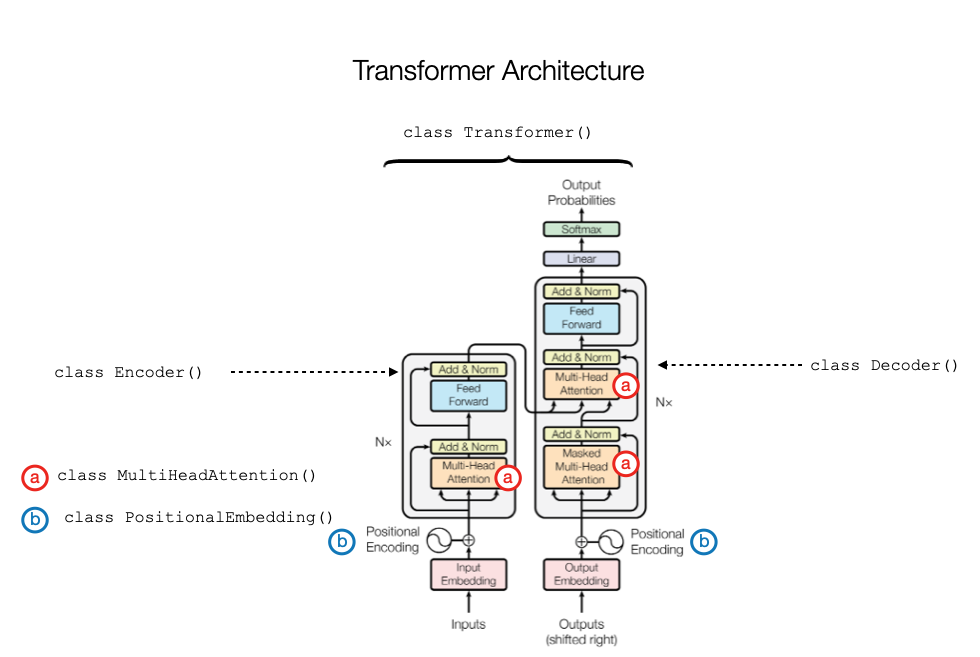

In [9]:
class PositionalEmbedding(nn.Module):
    """
    A PyTorch module that computes and applies positional encodings to the input
    token embeddings. This class is typically used in Transformer-based models to
    inject positional information, as these models do not inherently have any
    notion of token order.

    Positional encodings are based on a sinusoidal function, as described in the
    "Attention is All You Need" paper (Vaswani et al., 2017). The positional
    encodings are added to the token embeddings to retain the order of tokens.

    Args:
        d_model (int): The dimension of the model's token embeddings. This is the
        size of the input feature vectors.
        max_seq_len (int, optional): The maximum sequence length for which the
                                     positional encodings are computed. Default
                                     value is `MAX_SEQ_LEN`. The length should
                                     accommodate the longest input sequence
                                     expected during model inference or training.

    Attributes:
        pos_embed_matrix (Tensor): A matrix of shape `(max_seq_len, d_model)`
                                   containing the precomputed sinusoidal positional
                                   encodings. The matrix is initialized with zeros
                                   and filled with sine and cosine functions.

    Methods:
        forward(x):
            Adds the positional encodings to the input token embeddings `x`. The
            input `x` should have shape `(sequence_length, batch_size, d_model)`
            or similar, and the method will return the input embeddings with
            positional encodings added to them.
    """

    def __init__(self, d_model, max_seq_len = MAX_SEQ_LEN):
        """
        Initializes the PositionalEmbedding module.

        Args:
            d_model (int): The dimension of the model's token embeddings.
            max_seq_len (int, optional): The maximum sequence length. Default is
            `MAX_SEQ_LEN`.
        """
        super().__init__()
        self.pos_embed_matrix = torch.zeros(max_seq_len, d_model, device=device)
        token_pos = torch.arange(0, max_seq_len, dtype = torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float()
                             * (-math.log(10000.0)/d_model))
        self.pos_embed_matrix[:, 0::2] = torch.sin(token_pos * div_term)
        self.pos_embed_matrix[:, 1::2] = torch.cos(token_pos * div_term)
        self.pos_embed_matrix = self.pos_embed_matrix.unsqueeze(0).transpose(0,1)

    def forward(self, x):
        """
        Adds positional encodings to the input token embeddings `x`.

        Args:
            x (Tensor): The input tensor containing token embeddings of shape
                        `(sequence_length, batch_size, d_model)`, or a similar
                        shape. `x.size(0)` should be the sequence length.

        Returns:
            Tensor: The input tensor `x` with positional encodings added. The
                     shape remains the same as `x`.
        """
        return x + self.pos_embed_matrix[:x.size(0), :]


In [10]:
class MultiHeadAttention(nn.Module):
    """
    Implements the Multi-Head Attention mechanism used in Transformer models, as
    described in the "Attention is All You Need" paper (Vaswani et al., 2017).
    Multi-head attention allows the model to focus on different parts of the
    input sequence using multiple attention heads.

    The attention mechanism is based on scaled dot-product attention, and the
    multiple heads allow the model to jointly attend to information from different
    representation subspaces at different positions.

    Args:
        d_model (int, optional): The dimension of the model's token embeddings
                                 (also the size of the query, key, and value
                                 vectors). Default is 512.
        num_heads (int, optional): The number of attention heads. The input
                                   dimension `d_model` must be divisible by
                                   `num_heads`. Default is 8.

    Attributes:
        d_v (int): The dimension of the value vectors for each head (`d_model // num_heads`).
        d_k (int): The dimension of the key vectors for each head (`d_model // num_heads`).
        num_heads (int): The number of attention heads.
        W_q (nn.Linear): Linear layer for generating query vectors (Q) from the input.
        W_k (nn.Linear): Linear layer for generating key vectors (K) from the input.
        W_v (nn.Linear): Linear layer for generating value vectors (V) from the input.
        W_o (nn.Linear): Linear layer for output transformation after multi-head attention is applied.

    Methods:
        forward(Q, K, V, mask=None):
            Applies multi-head attention to the input queries (Q), keys (K), and
            values (V), and returns the weighted values and the attention weights.
            Optionally, a mask can be provided to mask out certain positions in
            the attention computation (e.g., padding tokens).

        scale_dot_product(Q, K, V, mask=None):
            Computes the scaled dot-product attention mechanism, which includes
            the computation of attention scores, applying the mask (if provided),
            and calculating the weighted sum of values.

    """

    def __init__(self, d_model = 512, num_heads = 8):
        """
        Initializes the MultiHeadAttention module.

        Args:
            d_model (int, optional): The dimension of the input embeddings (default is 512).
            num_heads (int, optional): The number of attention heads (default is 8).
        """
        super().__init__()
        assert d_model % num_heads == 0, 'Embedding size not compatible with num heads'

        self.d_v = d_model // num_heads
        self.d_k = self.d_v
        self.num_heads = num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V, mask = None):
        """
        Performs multi-head attention on the input queries (Q), keys (K), and values (V).

        Args:
            Q (Tensor): The query tensor of shape `(batch_size, seq_len, d_model)`.
            K (Tensor): The key tensor of shape `(batch_size, seq_len, d_model)`.
            V (Tensor): The value tensor of shape `(batch_size, seq_len, d_model)`.
            mask (Tensor, optional): A tensor of shape `(batch_size, seq_len)` to
                                     mask certain positions (e.g., padding tokens)
                                     in the attention computation. Default is `None`.

        Returns:
            Tuple: A tuple containing:
                - weighted_values (Tensor): The result of the attention mechanism
                  applied to the values, with shape `(batch_size, seq_len, d_model)`.
                - attention (Tensor): The attention weights, of shape `(batch_size,
                  num_heads, seq_len, seq_len)`.
        """
        batch_size = Q.size(0)
        '''
        Q, K, V -> [batch_size, seq_len, num_heads*d_k]
        after transpose Q, K, V -> [batch_size, num_heads, seq_len, d_k]
        '''
        Q = self.W_q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2 )
        K = self.W_k(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2 )
        V = self.W_v(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2 )

        weighted_values, attention = self.scale_dot_product(Q, K, V, mask)
        weighted_values = weighted_values.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads*self.d_k)
        weighted_values = self.W_o(weighted_values)

        return weighted_values, attention

    def scale_dot_product(self, Q, K, V, mask = None):
        """
        Computes the scaled dot-product attention mechanism.

        Args:
            Q (Tensor): The query tensor of shape `(batch_size, num_heads, seq_len, d_k)`.
            K (Tensor): The key tensor of shape `(batch_size, num_heads, seq_len, d_k)`.
            V (Tensor): The value tensor of shape `(batch_size, num_heads, seq_len, d_k)`.
            mask (Tensor, optional): A tensor of shape `(batch_size, seq_len)` to mask
                                     certain positions in the attention computation.
                                     Default is `None`

        Returns:
            Tuple: A tuple containing:
                - weighted_values (Tensor): The weighted sum of values based on
                                            attention scores.
                - attention (Tensor): The attention weights, of shape `(batch_size,
                                                                        num_heads,
                                                                        seq_len,
                                                                        seq_len)`
        """
                                                                            # References to Scale Dot Product
                                                                            # Attention diagram below
                                                                            # -------------------------------
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k) # (A)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)                    # (B)
        attention = F.softmax(scores, dim=-1)                               # (C)
        weighted_values = torch.matmul(attention, V)                        # (D)

        return weighted_values, attention


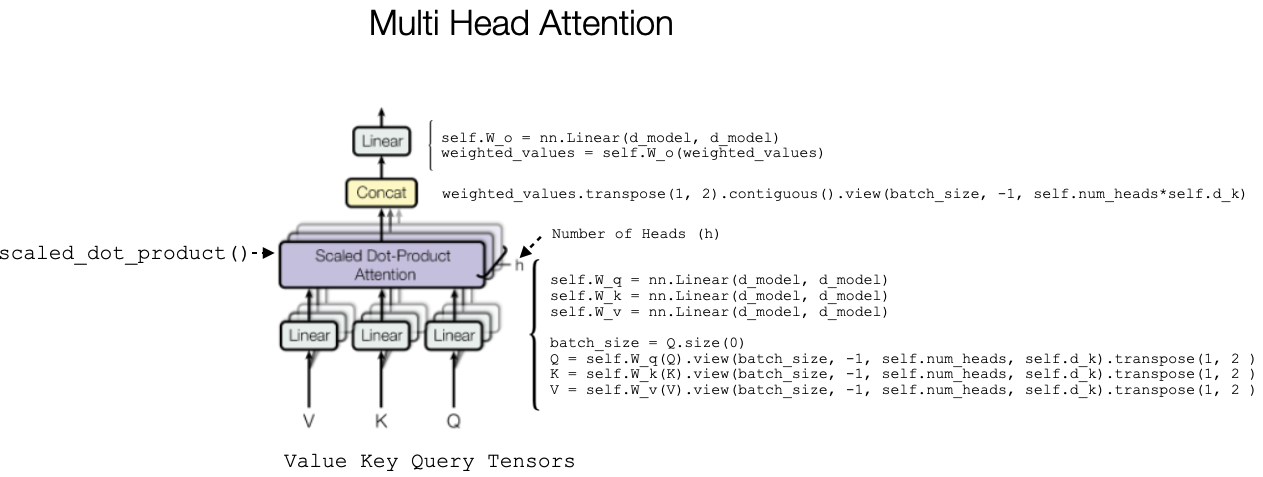

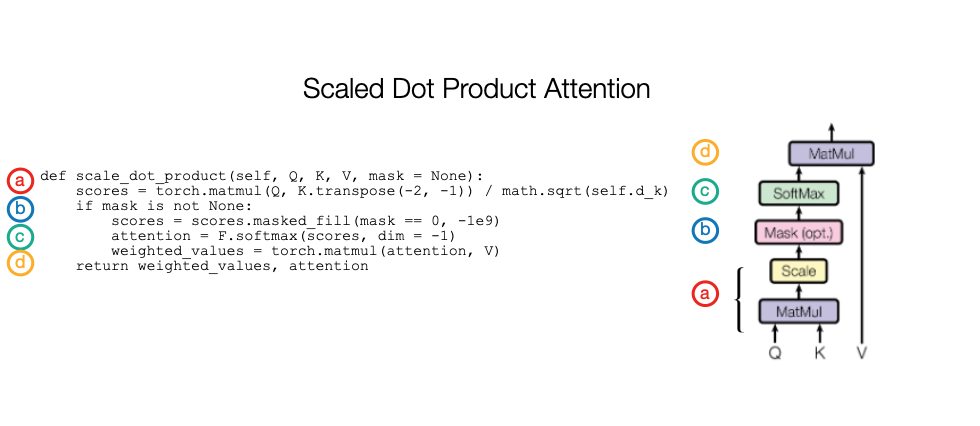

In [11]:
class PositionFeedForward(nn.Module):
    """
    A  feed-forward neural network with a ReLU activation function.
    This module consists of two linear layers: an input-to-hidden layer
    and a hidden-to-output layer. The input is first passed through the
    first linear layer, followed by a ReLU activation, and then passed
    through the second linear layer to produce the output.

    Args:
        d_model (int): The dimension of the input and output features.
        d_ff (int): The number of features in the hidden layer.

    Attributes:
        linear1 (nn.Linear): The first linear transformation from input
                             (d_model) to hidden space (d_ff).
        linear2 (nn.Linear): The second linear transformation from hidden
                             space (d_ff) to output (d_model).

    Methods:
        forward(x):
            Passes the input `x` through the feed-forward network:
            1. Linear transformation -> ReLU activation -> Linear transformation.
            2. Returns the output tensor after the final linear transformation.
    """

    def __init__(self, d_model, d_ff):
        """
        Initializes the PositionFeedForward class with two linear layers.

        Args:
            d_model (int): The size of the input and output feature dimensions.
            d_ff (int): The number of units in the hidden layer.
        """
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        """
        Forward pass through the feed-forward network.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, d_model).

        Returns:
            torch.Tensor: Output tensor with shape (batch_size, d_model).
        """
        return self.linear2(F.relu(self.linear1(x)))


In [12]:
class EncoderSubLayer(nn.Module):
    """
    A single layer of the encoder in a Transformer model. It consists of two main
    components:
    1. Multi-Head Self-Attention: This component allows the model to attend to
       different positions in the input sequence.
    2. Position-wise Feed-Forward Network (FFN): A two-layer fully connected
       network applied independently to each position.

    Each of these components is followed by layer normalization and dropout to
    improve training and generalization.

    Args:
        d_model (int): The dimension of the model's token embeddings and the
                       hidden states.
        num_heads (int): The number of attention heads in the multi-head attention
                         mechanism.
        d_ff (int): The dimensionality of the hidden layer in the feed-forward network.
        dropout (float, optional): The dropout probability to apply after the
                                   attention and feed-forward network.
                                   Default is 0.1.

    Attributes:
        self_attn (MultiHeadAttention): The multi-head attention layer.
        ffn (PositionFeedForward): The position-wise feed-forward network.
        norm1 (nn.LayerNorm): The layer normalization applied after the
                              self-attention step.
        norm2 (nn.LayerNorm): The layer normalization applied after the
                              feed-forward network.
        dropout1 (nn.Dropout): The dropout layer applied after the self-attention.
        dropout2 (nn.Dropout): The dropout layer applied after the feed-forward
                            network.

    Methods:
        forward(x, mask=None):
            Performs a forward pass through the sub-layer, which includes:
            - Self-attention with residual connection and dropout.
            - Layer normalization after the attention.
            - Feed-forward network with residual connection and dropout.
            - Final layer normalization.
    """

    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        """
        Initializes the EncoderSubLayer.

        Args:
            d_model (int): The dimension of the model's token embeddings and
                            hidden states.
            num_heads (int): The number of attention heads in the multi-head
                             attention mechanism.
            d_ff (int): The dimension of the hidden layer in the feed-forward
                        network.
            dropout (float, optional): The dropout probability to apply after the
                                       attention and feed-forward network.
                                       Default is 0.1.
        """
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.droupout1 = nn.Dropout(dropout)
        self.droupout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        """
        Performs the forward pass of the encoder sub-layer.

        Args:
            x (Tensor): The input tensor of shape `(batch_size, seq_len, d_model)`.
            mask (Tensor, optional): A tensor of shape `(batch_size, seq_len)` to
                                     mask certain positions.
                                     Default is `None`.

        Returns:
            Tensor: The output tensor after applying self-attention, feed-forward
                    network, dropout, and layer normalization.
        """
        attention_score, _ = self.self_attn(x, x, x, mask)
        x = x + self.droupout1(attention_score)
        x = self.norm1(x)
        x = x + self.droupout2(self.ffn(x))
        return self.norm2(x)


In [13]:

class Encoder(nn.Module):
    """
    The full encoder module consisting of multiple encoder layers (EncoderSubLayer).
    Each encoder layer performs multi-head self-attention followed by a
    position-wise feed-forward network. The encoder is used to process the input
    sequence and generate hidden states for each token in the sequence.

    Args:
        d_model (int): The dimension of the model's token embeddings and hidden
                       states.
        num_heads (int): The number of attention heads in each multi-head attention
                         mechanism.
        d_ff (int): The dimensionality of the hidden layer in the feed-forward
                    network.
        num_layers (int): The number of encoder layers to stack.
        dropout (float, optional): The dropout probability to apply in each
                                   encoder layer. Default is 0.1.

    Attributes:
        layers (nn.ModuleList): A list of `EncoderSubLayer` layers, stacked to
                                form the full encoder.
        norm (nn.LayerNorm): The final layer normalization applied after processing
                             all encoder layers.

    Methods:
        forward(x, mask=None):
            Performs a forward pass through all encoder layers, and applies layer
            normalization to the output.
    """

    def __init__(self, d_model, num_heads, d_ff, num_layers, dropout=0.1):
        """
        Initializes the Encoder.

        Args:
            d_model (int): The dimension of the model's token embeddings and
                           hidden states.
            num_heads (int): The number of attention heads in each multi-head
                             attention mechanism.
            d_ff (int): The dimensionality of the hidden layer in the feed-forward
                        network.
            num_layers (int): The number of encoder layers to stack.
            dropout (float, optional): The dropout probability to apply in each
                                       encoder layer. Default is 0.1.
        """
        super().__init__()
        self.layers = nn.ModuleList([EncoderSubLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        """
        Performs the forward pass through the encoder, applying each encoder
        sub-layer.

        Args:
            x (Tensor): The input tensor of shape `(batch_size, seq_len, d_model)`.
            mask (Tensor, optional): A tensor of shape `(batch_size, seq_len)`
                                     to mask certain positions (e.g., padding tokens).
                                     Default is `None`.

        Returns:
            Tensor: The output tensor after passing through all encoder layers,
                    with shape `(batch_size, seq_len, d_model)`.
        """
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [14]:
class DecoderSubLayer(nn.Module):
    """
    A single layer of the decoder in a Transformer model. It consists of three
    main components:
    1. Multi-Head Self-Attention: This component allows the decoder to attend to
       its own previous outputs.
    2. Multi-Head Cross-Attention: This component allows the decoder to attend to
       the encoder's output.
    3. Position-wise Feed-Forward Network (FFN): A two-layer fully connected
       network applied independently to each position.

    Each of these components is followed by layer normalization and dropout to
    improve training and generalization.

    Args:
        d_model (int): The dimension of the model's token embeddings and hidden
                       states.
        num_heads (int): The number of attention heads in the multi-head attention
                         mechanisms.
        d_ff (int): The dimensionality of the hidden layer in the feed-forward
                    network.
        dropout (float, optional): The dropout probability to apply after the
                                   attention and feed-forward network.
                                   Default is 0.1.

    Attributes:
        self_attn (MultiHeadAttention): The multi-head self-attention layer for
                                        attending to previous decoder outputs.
        cross_attn (MultiHeadAttention): The multi-head attention layer for
                                         attending to the encoder's output.
        feed_forward (PositionFeedForward): The position-wise feed-forward network.
        norm1 (nn.LayerNorm): The layer normalization applied after the self-attention
                              step.
        norm2 (nn.LayerNorm): The layer normalization applied after the cross-attention
                              step.
        norm3 (nn.LayerNorm): The layer normalization applied after the feed-forward
                              network.
        dropout1 (nn.Dropout): The dropout layer applied after the self-attention.
        dropout2 (nn.Dropout): The dropout layer applied after the cross-attention.
        dropout3 (nn.Dropout): The dropout layer applied after the feed-forward
                               network.

    Methods:
        forward(x, encoder_output, target_mask=None, encoder_mask=None):
            Performs a forward pass through the decoder sub-layer, which includes:
            - Self-attention with residual connection and dropout.
            - Cross-attention with residual connection and dropout.
            - Feed-forward network with residual connection and dropout.
            - Final layer normalization.
    """

    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        """
        Initializes the DecoderSubLayer.

        Args:
            d_model (int): The dimension of the model's token embeddings and
                            hidden states.
            num_heads (int): The number of attention heads in the multi-head
                             attention mechanisms.
            d_ff (int): The dimension of the hidden layer in the feed-forward
                        network.
            dropout (float, optional): The dropout probability to apply after the
                                       attention and feed-forward network.
                                       Default is 0.1.
        """
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, encoder_output, target_mask=None, encoder_mask=None):
        """
        Performs the forward pass of the decoder sub-layer.

        Args:
            x (Tensor): The input tensor of shape `(batch_size, seq_len, d_model)`
                        representing the decoder's previous output.
            encoder_output (Tensor): The output tensor of the encoder, of shape
                                    `(batch_size, seq_len, d_model)`.
            target_mask (Tensor, optional): A tensor of shape `(batch_size, seq_len)`
                                            to mask certain positions in the target
                                            sequence
                                             Default is `None`.
            encoder_mask (Tensor, optional): A tensor of shape `(batch_size, seq_len)`
                                             to mask certain positions in the
                                             encoder's output
                                             Default is `None`.

        Returns:
            Tensor: The output tensor after applying self-attention, cross-attention,
                    feed-forward network, dropout, and layer normalization.
        """
        attention_score, _ = self.self_attn(x, x, x, target_mask)
        x = x + self.dropout1(attention_score)
        x = self.norm1(x)

        encoder_attn, _ = self.cross_attn(x, encoder_output, encoder_output, encoder_mask)
        x = x + self.dropout2(encoder_attn)
        x = self.norm2(x)

        ff_output = self.feed_forward(x)
        x = x + self.dropout3(ff_output)
        return self.norm3(x)



In [15]:
class Decoder(nn.Module):
    """
    The full decoder module consisting of multiple decoder layers (DecoderSubLayer).
    Each decoder layer performs self-attention, cross-attention over the encoder's
    output, and a position-wise feed-forward network. The decoder processes the target
    sequence (along with the encoder output) to generate the final output sequence.

    Args:
        d_model (int): The dimension of the model's token embeddings and hidden
                       states.
        num_heads (int): The number of attention heads in each multi-head attention
                         mechanism.
        d_ff (int): The dimensionality of the hidden layer in the feed-forward network.
        num_layers (int): The number of decoder layers to stack.
        dropout (float, optional): The dropout probability to apply in each decoder
                                   layer. Default is 0.1.

    Attributes:
        layers (nn.ModuleList): A list of `DecoderSubLayer` layers, stacked to form
                                the full decoder.
        norm (nn.LayerNorm): The final layer normalization applied after processing
                              all decoder layers.

    Methods:
        forward(x, encoder_output, target_mask, encoder_mask):  Performs a
        forward pass through all decoder layers, and applies layer normalization
        to the output.
"""


    def __init__(self, d_model, num_heads, d_ff, num_layers, dropout=0.1):
        """
        Initializes the Decoder.

        Args:
            d_model (int): The dimension of the model's token embeddings and hidden
                           states.
            num_heads (int): The number of attention heads in each multi-head
                              attention mechanism.
            d_ff (int): The dimensionality of the hidden layer in the feed-forward
                        network.
            num_layers (int): The number of decoder layers to stack.
            dropout (float, optional): The dropout probability to apply in each
                                        decoder layer. Default is 0.1.
        """
        super().__init__()
        self.layers = nn.ModuleList([DecoderSubLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, encoder_output, target_mask, encoder_mask):
        """
        Performs the forward pass through the decoder, applying each decoder sub-layer.

        Args:
            x (Tensor): The input tensor of shape `(batch_size, seq_len, d_model)`
                        representing the decoder's previous output.
            encoder_output (Tensor): The output tensor from the encoder, of shape
                                     `(batch_size, seq_len, d_model)`.
            target_mask (Tensor): A tensor of shape `(batch_size, seq_len)` to
                                   mask certain positions in the target sequence
            encoder_mask (Tensor): A tensor of shape `(batch_size, seq_len)` to
                                   mask certain positions in the encoder's output

        Returns:
            Tensor: The output tensor after passing through all decoder layers,
                    with shape `(batch_size, seq_len, d_model)`.
        """
        for layer in self.layers:
            x = layer(x, encoder_output, target_mask, encoder_mask)

        return self.norm(x)

In [16]:
class Transformer(nn.Module):
"""
    A PyTorch implementation of the Transformer model as described in the paper
    'Attention is All You Need' (Vaswani et al., 2017). This model is widely used
    for sequence-to-sequence tasks such as machine translation, text summarization,
    and more.

    The Transformer model consists of an encoder-decoder architecture with
    multi-head self-attention mechanisms, position-wise feedforward networks, and
    positional encoding to capture word order.

    Args:
        d_model (int): The dimensionality of the model's embeddings (both input
                       and output).
        num_heads (int): The number of attention heads in each multi-head attention
                         layer.
        d_ff (int): The dimensionality of the feedforward layers in the transformer
                    blocks.
        num_layers (int): The number of encoder and decoder layers in the model.
        input_vocab_size (int): The size of the input vocabulary.
        target_vocab_size (int): The size of the target vocabulary.
        max_len (int, optional): The maximum length of input/output sequences.
                                  Default is `MAX_SEQ_LEN`.
        dropout (float, optional): Dropout rate for regularization. Default is 0.1.

    Attributes:
        encoder_embedding (nn.Embedding): Embedding layer for the input (source)
                                          sequences.
        decoder_embedding (nn.Embedding): Embedding layer for the target sequences.
        pos_embedding (PositionalEmbedding): Positional encoding for input and
                                             target sequences.
        encoder (Encoder): The encoder module that processes the input sequence.
        decoder (Decoder): The decoder module that generates the output sequence.
        output_layer (nn.Linear): Final linear layer that projects the decoder's
                                  output to the target vocabulary space.

    Methods:
        forward(source, target):
            Performs a forward pass through the transformer model, including
            embedding, positional encoding, and processing through the encoder and
            decoder.
        mask(source, target):
            Creates masks for the source and target sequences to prevent attending
            to padded values and to ensure that the decoder doesn't attend to future
            tokens during training.
"""


    def __init__(self, d_model, num_heads, d_ff, num_layers,
                 input_vocab_size, target_vocab_size,
                 max_len=MAX_SEQ_LEN, dropout=0.1):
        """
        Initializes the Transformer model with embeddings, positional encodings,
        encoder and decoder layers, and an output projection layer.

        Args:
            d_model (int): Dimensionality of model embeddings.
            num_heads (int): Number of attention heads in each multi-head attention layer.
            d_ff (int): Dimensionality of feedforward layers.
            num_layers (int): Number of encoder/decoder layers.
            input_vocab_size (int): Input vocabulary size.
            target_vocab_size (int): Target vocabulary size.
            max_len (int, optional): Maximum sequence length for positional encoding.
            dropout (float, optional): Dropout rate for regularization.
        """
        super().__init__()
        self.encoder_embedding = nn.Embedding(input_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(target_vocab_size, d_model)
        self.pos_embedding = PositionalEmbedding(d_model, max_len)
        self.encoder = Encoder(d_model, num_heads, d_ff, num_layers, dropout)
        self.decoder = Decoder(d_model, num_heads, d_ff, num_layers, dropout)
        self.output_layer = nn.Linear(d_model, target_vocab_size)

    def forward(self, source, target):
        """
        Forward pass through the Transformer model.

        Args:
            source (torch.Tensor): The input sequence (source) tensor with shape
                                   (batch_size, seq_len).
            target (torch.Tensor): The target sequence tensor with shape (batch_size,
                                    seq_len).

        Returns:
            torch.Tensor: The model's output, which is a tensor of shape
                          (batch_size, target_seq_len, target_vocab_size).
        """
        # Encoder mask
        source_mask, target_mask = self.mask(source, target)
        # Embedding and positional Encoding
        source = self.encoder_embedding(source) * math.sqrt(self.encoder_embedding.embedding_dim)
        source = self.pos_embedding(source)
        # Encoder
        encoder_output = self.encoder(source, source_mask)

        # Decoder embedding and postional encoding
        target = self.decoder_embedding(target) * math.sqrt(self.decoder_embedding.embedding_dim)
        target = self.pos_embedding(target)
        # Decoder
        output = self.decoder(target, encoder_output, target_mask, source_mask)

        return self.output_layer(output)

    def mask(self, source, target):
        """
        Creates source and target masks to prevent the model from attending to
        padded tokens and to ensure that the decoder does not attend to future
        tokens.

        Args:
            source (torch.Tensor): The input sequence (source) tensor.
            target (torch.Tensor): The target sequence tensor.

        Returns:
            tuple: A tuple of source and target masks:
                - source_mask (torch.Tensor): Mask for the source sequence.
                - target_mask (torch.Tensor): Mask for the target sequence.
        """
        source_mask = (source != 0).unsqueeze(1).unsqueeze(2)
        target_mask = (target != 0).unsqueeze(1).unsqueeze(2)
        size = target.size(1)
        no_mask = torch.tril(torch.ones((1, size, size), device=device)).bool()
        target_mask = target_mask & no_mask
        return source_mask, target_mask


#### Simple test

In [17]:
seq_len_source = 10        # Length of the input sequence - 10 Tokens
seq_len_target = 10        # Length of the output sequence (target sequence) - 10 tokens
batch_size = 2             # Number of sequences in a batch
input_vocab_size = 50      # Size of the input vocabulary (number of distinct tokens)
target_vocab_size = 50     # Size of the target vocabulary (number of distinct tokens)

source = torch.randint(1, input_vocab_size, (batch_size, seq_len_source))
target = torch.randint(1, target_vocab_size, (batch_size, seq_len_target))


In [18]:
# Set model hyperparameters
d_model = 512        # The dimensionality of the model's token embeddings and hidden states -> As recommended in the paper
num_heads = 8        # The number of attention heads in the multi-head attention mechanism -> As recommended in the paper
d_ff = 2048          # The dimensionality of the hidden layer in the position-wise feed-forward network -> Paper recommends 4 * d_model
num_layers = 6       # The number of layers in both the encoder and decoder -> As recommended in the paper

model = Transformer(d_model, num_heads, d_ff, num_layers,
                    input_vocab_size, target_vocab_size,
                    max_len=MAX_SEQ_LEN, dropout=0.1)

model = model.to(device)

source = source.to(device)
target = target.to(device)

In [19]:
output = model(source, target)

In [20]:
# Expected output shape -> [batch, seq_len_target, target_vocab_size] i.e. [2, 10, 50]
print(f'ouput.shape {output.shape}')

ouput.shape torch.Size([2, 10, 50])


### Translator Eng-Spa

In [21]:
#PATH = '/media/pepe/DataUbuntu/Databases/spanish_english/spa_eng/eng-spa.txt'
#The path is stored in output_file_path


In [22]:
with open(output_file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()
eng_spa_pairs = [line.strip().split('\t') for line in lines if '\t' in line]

In [23]:
eng_spa_pairs[:10]

[['Go.', 'Váyase.'],
 ['Ah!', '¡Anda!'],
 ['Ok!', '¡OK!'],
 ['No.', 'No.'],
 ['So?', '¿Y qué?'],
 ['OK.', '¡Órale!'],
 ['Go!', '¡Sal!'],
 ['Go!', '¡Ve!'],
 ['Ow!', '¡Ay!'],
 ['Go.', 'Vaya.']]

In [24]:
eng_sentences = [pair[0] for pair in eng_spa_pairs]
spa_sentences = [pair[1] for pair in eng_spa_pairs]

In [25]:
print(eng_sentences[:10])
print(spa_sentences[:10])


['Go.', 'Ah!', 'Ok!', 'No.', 'So?', 'OK.', 'Go!', 'Go!', 'Ow!', 'Go.']
['Váyase.', '¡Anda!', '¡OK!', 'No.', '¿Y qué?', '¡Órale!', '¡Sal!', '¡Ve!', '¡Ay!', 'Vaya.']


In [26]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[á]+", "a", sentence)
    sentence = re.sub(r"[é]+", "e", sentence)
    sentence = re.sub(r"[í]+", "i", sentence)
    sentence = re.sub(r"[ó]+", "o", sentence)
    sentence = re.sub(r"[ú]+", "u", sentence)
    sentence = re.sub(r"[^a-z]+", " ", sentence)
    sentence = sentence.strip()
    sentence = '<sos> ' + sentence + ' <eos>'
    return sentence

In [27]:
s1 = '¿Hola @ cómo estás? 123'

In [28]:
print(s1)
print(preprocess_sentence(s1))

¿Hola @ cómo estás? 123
<sos> hola como estas <eos>


In [29]:
eng_sentences = [preprocess_sentence(sentence) for sentence in eng_sentences]
spa_sentences = [preprocess_sentence(sentence) for sentence in spa_sentences]

In [30]:
spa_sentences[:10]

['<sos> vayase <eos>',
 '<sos> anda <eos>',
 '<sos> ok <eos>',
 '<sos> no <eos>',
 '<sos> y que <eos>',
 '<sos> orale <eos>',
 '<sos> sal <eos>',
 '<sos> ve <eos>',
 '<sos> ay <eos>',
 '<sos> vaya <eos>']

In [31]:
def build_vocab(sentences):
    """
    Builds a vocabulary from a list of sentences, where each sentence is a string
    of space-separated words.
    The vocabulary consists of two dictionaries:
    - `word2idx`: A mapping from words to unique integer indices.
    - `idx2word`: A mapping from integer indices back to words.

    Special tokens are added to the vocabulary:
    - `<pad>`: The padding token, assigned the index 0.
    - `<unk>`: The unknown token for words not in the vocabulary, assigned the
               index 1.

    The vocabulary is built based on word frequency, with the most frequent words
    assigned the lowest indices.

    Args:
        sentences (list of str): A list of sentences (strings), where each sentence
                                 is a space-separated string of words.

    Returns:
        tuple: A tuple containing:
            - word2idx (dict): A dictionary mapping words (str) to integer indices (int).
            - idx2word (dict): A dictionary mapping integer indices (int) to words (str).

    Notes:
        - The index 0 is reserved for the `<pad>` token.
        - The index 1 is reserved for the `<unk>` token, used for out-of-vocabulary words.
    """
    words = [word for sentence in sentences for word in sentence.split()]
    word_count = Counter(words)
    sorted_word_counts = sorted(word_count.items(), key=lambda x:x[1], reverse=True)
    word2idx = {word: idx for idx, (word, _) in enumerate(sorted_word_counts, 2)}
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1
    idx2word = {idx: word for word, idx in word2idx.items()}
    return word2idx, idx2word

In [32]:
eng_word2idx, eng_idx2word = build_vocab(eng_sentences)
spa_word2idx, spa_idx2word = build_vocab(spa_sentences)
eng_vocab_size = len(eng_word2idx)
spa_vocab_size = len(spa_word2idx)

In [33]:
print(eng_vocab_size, spa_vocab_size)

27650 46929


In [34]:
class EngSpaDataset(Dataset):
    """
    A dataset class for loading pairs of English and Spanish sentences for machine
    translation tasks, inheriting from PyTorch's `Dataset` class. The dataset is used
    to prepare sentence pairs where each sentence in English and Spanish is converted
    to a sequence of word indices using provided word-to-index mappings.

    Args:
        eng_sentences (list of str): A list of English sentences (strings) for the
                                     dataset.
        spa_sentences (list of str): A list of Spanish sentences (strings)
                                     corresponding to the English sentences.
        eng_word2idx (dict): A dictionary mapping each English word (str) to its
                             index (int).
        spa_word2idx (dict): A dictionary mapping each Spanish word (str) to its
                             index (int).

    Attributes:
        eng_sentences (list of str): The list of English sentences.
        spa_sentences (list of str): The list of Spanish sentences.
        eng_word2idx (dict): The word-to-index mapping for English words.
        spa_word2idx (dict): The word-to-index mapping for Spanish words.

    Methods:
        __len__():
            Returns the number of sentence pairs in the dataset (same as the length
            of `eng_sentences`).
        __getitem__(idx):
            Returns the word indices for the English and Spanish sentences at the
            given index `idx`.
    """


    def __init__(self, eng_sentences, spa_sentences, eng_word2idx, spa_word2idx):
        """
        Initializes the dataset with English and Spanish sentences and word-to-index
         mappings.

        Args:
            eng_sentences (list of str): A list of English sentences (strings).
            spa_sentences (list of str): A list of Spanish sentences (strings).
            eng_word2idx (dict): A dictionary mapping English words to their
                                respective indices.
            spa_word2idx (dict): A dictionary mapping Spanish words to their
                                 respective indices.
        """
        self.eng_sentences = eng_sentences
        self.spa_sentences = spa_sentences
        self.eng_word2idx = eng_word2idx
        self.spa_word2idx = spa_word2idx

    def __len__(self):
        """
        Returns the length of the dataset, i.e., the number of sentence pairs.

        Returns:
            int: The number of sentence pairs in the dataset
        """
        return len(self.eng_sentences)

    def __getitem__(self, idx):
        """
        Retrieves the word indices for the English and Spanish sentences at a
        given index `idx`.

        Args:
            idx (int): The index of the sentence pair to retrieve.

        Returns:
            tuple: A tuple of two tensors:
                - torch.Tensor: The indices of words in the English sentence.
                - torch.Tensor: The indices of words in the Spanish sentence.
        """
        eng_sentence = self.eng_sentences[idx]
        spa_sentence = self.spa_sentences[idx]

        eng_idxs = [self.eng_word2idx.get(word, self.eng_word2idx['<unk>']) for word in eng_sentence.split()]
        spa_idxs = [self.spa_word2idx.get(word, self.spa_word2idx['<unk>']) for word in spa_sentence.split()]

        return torch.tensor(eng_idxs), torch.tensor(spa_idxs)


In [35]:
def collate_fn(batch):
    """
    Collate function for batching sequences of English and Spanish sentences.

    This function is used to prepare a batch of English-Spanish sentence pairs for
    input into a model during training or evaluation. It handles the following
    operations:
    1. Truncates each sequence to a maximum length (`MAX_SEQ_LEN`).
    2. Detaches the sequences from their computation graph to ensure no gradients
       are tracked.
    3. Pads the sequences to ensure all sentences in the batch have the same length.

    The function assumes that each item in the batch is a tuple containing a pair
    of English and Spanish sentence tensors (as indices) that need to be padded
    for batching.

    Args:
        batch (list of tuples): A list of tuples, where each tuple contains:
            - An English sentence tensor (torch.Tensor) of word indices.
            - A Spanish sentence tensor (torch.Tensor) of word indices.

    Returns:
        tuple: A tuple containing two tensors:
            - eng_batch (torch.Tensor): A padded tensor of English sentence indices
              of shape (batch_size, max_seq_len), where `max_seq_len` is determined
              by the padding.
            - spa_batch (torch.Tensor): A padded tensor of Spanish sentence indices
              of shape (batch_size, max_seq_len), where `max_seq_len` is determined
              by the padding.

        The padding value used for padding is `0` (assumed to be the index for the
        padding token).
    """


    eng_batch, spa_batch = zip(*batch)
    eng_batch = [seq[:MAX_SEQ_LEN].clone().detach() for seq in eng_batch]
    spa_batch = [seq[:MAX_SEQ_LEN].clone().detach() for seq in spa_batch]
    eng_batch = torch.nn.utils.rnn.pad_sequence(eng_batch, batch_first=True, padding_value=0)
    spa_batch = torch.nn.utils.rnn.pad_sequence(spa_batch, batch_first=True, padding_value=0)

    return eng_batch, spa_batch


In [36]:
def train(model, dataloader, loss_function, optimiser, epochs):
    """
    Trains the given model for a specified number of epochs using a provided
    dataloader, loss function, and optimizer. This function performs the training
    loop for a sequence-to-sequence model, where the model takes English sentences
    and generates Spanish translations.

    The function performs the following steps in each epoch:
    1. Loads a batch of English and Spanish sentence pairs from the dataloader.
    2. Prepares the target Spanish sentences for training (shifting them for
       input/output).
    3. Computes the model's output for the batch of sentences.
    4. Calculates the loss between the model's output and the ground-truth target.
    5. Computes gradients and updates the model's parameters using backpropagation
       and the optimizer.

    Args:
        model (nn.Module): The model to be trained, typically a sequence-to-sequence
                           model like Transformer.
        dataloader (DataLoader): The DataLoader that provides batches of sentence
                                 pairs for training.
        loss_function (nn.Module): The loss function to calculate the error between
                                   the model's predictions and the actual target.
        optimiser (torch.optim.Optimizer): The optimizer used to update the model's
                                           parameters during training.
        epochs (int): The number of epochs to train the model.

    Returns:
        None: The function trains the model in-place and prints the average loss
              at the end of each epoch.

    Notes:
        - The model is expected to take English sentences as input and produce
          Spanish sentence translations.
        - The `target_input` used for the decoder is the Spanish sentence shifted
          by one token (i.e., excluding the last token).
        - The `target_output` is the Spanish sentence shifted by one token (i.e.,
          excluding the first token) and flattened for loss computation.
    """

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for i, (eng_batch, spa_batch) in enumerate(dataloader):
            eng_batch = eng_batch.to(device)
            spa_batch = spa_batch.to(device)
            # Decoder preprocessing
            target_input = spa_batch[:, :-1]
            target_output = spa_batch[:, 1:].contiguous().view(-1)
            # Zero grads
            optimiser.zero_grad()
            # run model
            output = model(eng_batch, target_input)
            output = output.view(-1, output.size(-1))
            # loss\
            loss = loss_function(output, target_output)
            # gradient and update parameters
            loss.backward()
            optimiser.step()
            total_loss += loss.item()

        avg_loss = total_loss/len(dataloader)
        print(f'Epoch: {epoch}/{epochs}, Loss: {avg_loss:.4f}')

In [37]:
BATCH_SIZE = 64
dataset = EngSpaDataset(eng_sentences, spa_sentences, eng_word2idx, spa_word2idx)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [38]:
# Instatiate the model object as instance of Transformer()
model = Transformer(d_model=512, num_heads=8, d_ff=2048, num_layers=6,
                    input_vocab_size=eng_vocab_size, target_vocab_size=spa_vocab_size,
                    max_len=MAX_SEQ_LEN, dropout=0.1)

In [39]:
# Instatiate loss_funtion and Adam optimizer
model = model.to(device)
loss_function = nn.CrossEntropyLoss(ignore_index=0)
optimiser = optim.Adam(model.parameters(), lr=0.0001)


In [40]:
#
# Measure the time it takes to train the model
# this will be usefull to compare performance among different GPU
import time
import datetime
start_time = time.time()

# Train the model
train(model, dataloader, loss_function, optimiser, epochs = 10)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time to train the model: {str(datetime.timedelta(seconds=elapsed_time))}")



Epoch: 0/10, Loss: 3.6062
Epoch: 1/10, Loss: 2.2016
Epoch: 2/10, Loss: 1.7013
Epoch: 3/10, Loss: 1.3739
Epoch: 4/10, Loss: 1.1246
Epoch: 5/10, Loss: 0.9214
Epoch: 6/10, Loss: 0.7564
Epoch: 7/10, Loss: 0.6286
Epoch: 8/10, Loss: 0.5334
Epoch: 9/10, Loss: 0.4660
Time to train the model: 0:49:09.028521


In [49]:
def sentence_to_indices(sentence, word2idx):
    """
    Converts a sentence (string) into a list of word indices using the provided
    word-to-index dictionary.

    Args:
        sentence (str): The sentence to convert, consisting of space-separated
                         words.
        word2idx (dict): A dictionary mapping words (str) to indices (int).

    Returns:
        list: A list of integers representing the sentence's words as indices in
              the vocabulary. If a word is not found in the dictionary, it is
              replaced by the index of the '<unk>' token.
    """
    return [word2idx.get(word, word2idx['<unk>']) for word in sentence.split()]

def indices_to_sentence(indices, idx2word):
    """
    Converts a list of word indices back into a sentence (string) using the
    provided index-to-word dictionary.

    Args:
        indices (list): A list of word indices (int).
        idx2word (dict): A dictionary mapping indices (int) to words (str).

    Returns:
        str: A sentence formed by the words corresponding to the given indices,
             with '<pad>' tokens excluded.
    """
    return ' '.join([idx2word[idx] for idx in indices if idx in idx2word and idx2word[idx] != '<pad>'])

def translate_sentence(model, sentence, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device='cpu'):
    """
    Translates an input sentence from English to Spanish using the given
    translation model.

    Args:
        model (nn.Module): The trained model used for translation.
        sentence (str): The English sentence to translate.
        eng_word2idx (dict): A dictionary mapping English words to indices.
        spa_idx2word (dict): A dictionary mapping Spanish indices to words.
        max_len (int, optional): The maximum length for the translated sentence.
                                 Default is `MAX_SEQ_LEN`.
        device (str, optional): The device to run the model on ('cpu' or 'cuda').
                                Default is 'cpu'.

    Returns:
        str: The translated Spanish sentence as a string.
    """
    model.eval()
    sentence = preprocess_sentence(sentence)
    input_indices = sentence_to_indices(sentence, eng_word2idx)
    input_tensor = torch.tensor(input_indices).unsqueeze(0).to(device)

    # Initialize the target tensor with <sos> token
    tgt_indices = [spa_word2idx['<sos>']]
    tgt_tensor = torch.tensor(tgt_indices).unsqueeze(0).to(device)

    with torch.no_grad():
        for _ in range(max_len):
            output = model(input_tensor, tgt_tensor)
            output = output.squeeze(0)
            next_token = output.argmax(dim=-1)[-1].item()
            tgt_indices.append(next_token)
            tgt_tensor = torch.tensor(tgt_indices).unsqueeze(0).to(device)
            if next_token == spa_word2idx['<eos>']:
                break

    return indices_to_sentence(tgt_indices, spa_idx2word)

In [50]:
def evaluate_translations(model, sentences, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device='cpu'):
    """
    Evaluates a list of input sentences by translating them using the provided
    translation model. For each sentence, the input and the translated output
    are printed.

    Args:
        model (nn.Module): The trained translation model used to generate translations.
        sentences (list of str): A list of English sentences to be translated.
        eng_word2idx (dict): A dictionary mapping English words to indices.
        spa_idx2word (dict): A dictionary mapping Spanish indices to words.
        max_len (int, optional): The maximum length for the translated sentence.
                                 Default is `MAX_SEQ_LEN`.
        device (str, optional): The device on which the model is run ('cpu' or
                               'cuda'). Default is 'cpu'.

    Returns:
        None: The function prints the original sentence and its corresponding
               translation for each sentence.
    """
    for sentence in sentences:
        translation = translate_sentence(model, sentence, eng_word2idx, spa_idx2word, max_len, device)
        print(f'Input sentence: {sentence}')
        print(f'Traducción: {translation}')
        print()

# Example sentences to test the translator
test_sentences = [
    "Hello, how are you?",
    "I am learning artificial intelligence.",
    "Artificial intelligence is great.",
    "Good night!"
]

# Assuming the model is trained and loaded
# Set the device to 'cpu' or 'cuda' as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Evaluate translations
evaluate_translations(model, test_sentences, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device=device)


Input sentence: Hello, how are you?
Traducción: <sos> hola como estas <eos>

Input sentence: I am learning artificial intelligence.
Traducción: <sos> estoy aprendiendo inteligencia artificial <eos>

Input sentence: Artificial intelligence is great.
Traducción: <sos> la inteligencia artificial es grande <eos>

Input sentence: Good night!
Traducción: <sos> buenas noches <eos>



### Testing the Translator

In the following cells, we will test the English-to-Spanish translator using 20 sentences, each tested twice.

In the first attempt, we will use simple and concise sentences. For the second attempt, we will use more complex sentences from well-known authors and philosophers, including Octavio Paz, Friedrich Nietzsche, and Frank Herbert.

In [51]:
# Simple Sentences
test_sentences_1 = [
    "Hello, how are you ?",
    "Let's walk to school",
    "The grass is green",
    "Autumn begins today",
    "The dog runs",
    "The elevator is going up",
    "How much is this ?",
    "The radio is very entertaining",
    "I like programming",
    "I love that black guitar",
    "This is a wide road",
    "The river flows to the sea",
    "Planet Earth is between Venus and Mars ",
    "The tall boy plays with the ball",
    "The pretty girl dance with her hands up",
    "The bus has stopped",
    "I love pizza with cheese",
    "The carpet is red, not blue",
    "The eagle flys in the sky",
    "It is a beautiful sunset"
]

In [52]:
print(f"Number of simple sentences in list: {len(test_sentences_1)}")

Number of simple sentences in list: 20


In [53]:
# Evaluation of the model with simple sentences
evaluate_translations(model, test_sentences_1, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device=device)

Input sentence: Hello, how are you ?
Traducción: <sos> hola como estas <eos>

Input sentence: Let's walk to school
Traducción: <sos> caminemos a la escuela <eos>

Input sentence: The grass is green
Traducción: <sos> la hierba es verde <eos>

Input sentence: Autumn begins today
Traducción: <sos> hoy el oto o empieza <eos>

Input sentence: The dog runs
Traducción: <sos> el perro corre <eos>

Input sentence: The elevator is going up
Traducción: <sos> el ascensor esta subiendo <eos>

Input sentence: How much is this ?
Traducción: <sos> cuanto es esto <eos>

Input sentence: The radio is very entertaining
Traducción: <sos> la radio es muy entretenida <eos>

Input sentence: I like programming
Traducción: <sos> me gusta programacion <eos>

Input sentence: I love that black guitar
Traducción: <sos> me gusta esa guitarra negra <eos>

Input sentence: This is a wide road
Traducción: <sos> este es un camino ancho <eos>

Input sentence: The river flows to the sea
Traducción: <sos> el rio fluye hacia

In [54]:
# Complex Sentences
test_sentences_2 = [
    "Rome was the capital of the Roman empire",
    "The human race exaggerates everything",
    "A journey of a thousand miles begins with a single step",
    "If one ember is left alight",
    "Opportunities multiply as they are seized",
    "It's not over until it's over",
    "He who has a why to live can bear almost any how",
    "He who controls the spice, controls the universe",
    "Do, or do not. There is no try",
    "The best way to predict your future is to create it",
    "I came, I saw, I conquered",
    "Impossible is a word to be found only in the dictionary of fools",
    "In the face of the impossible, only the impossible is possible",
    "Liberty is the right of people to act as they wish",
    "Be kind whenever possible",
    "To be, or not to be, that is the question",
    "Knowing is not enough; we must apply",
    "Who looks outside, dreams; who looks inside, awakes",
    "The beginning is the most important part of the work",
    "Not all of us can do great things. But we can do small things with great love"
]


In [55]:
print(f"Number of complex sentences in list: {len(test_sentences_2)}")

Number of complex sentences in list: 20


In [56]:
# Evaluation of the model with complex sentences
evaluate_translations(model, test_sentences_2, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device=device)

Input sentence: Rome was the capital of the Roman empire
Traducción: <sos> roma fue la capital del imperio romano <eos>

Input sentence: The human race exaggerates everything
Traducción: <sos> la carrera lo exagera todo <eos>

Input sentence: A journey of a thousand miles begins with a single step
Traducción: <sos> un viaje a un solo paso a mil millas <eos>

Input sentence: If one ember is left alight
Traducción: <sos> si se deja de robar es gay <eos>

Input sentence: Opportunities multiply as they are seized
Traducción: <sos> se les escapan a las oportunidades como tienen <eos>

Input sentence: It's not over until it's over
Traducción: <sos> no es hasta que se termino <eos>

Input sentence: He who has a why to live can bear almost any how
Traducción: <sos> por que casi tiene un oso a quien puede vivir como para el <eos>

Input sentence: He who controls the spice, controls the universe
Traducción: <sos> el quien controla la especia del universo <eos>

Input sentence: Do, or do not. The

###Conclusion

Through this assignment, we gained valuable insights into the Transformer model and its architecture, along with the specific implementation details required to build it in Python. By applying the model to an English-to-Spanish translation task, we were able to observe both its elegant simplicity and power in action.

We trained the model on a corpus of 266,363 English sentences paired with their Spanish translations, completing training over 10 epochs. Afterward, we tested the model twice: first on simple English sentences, and then on more complex sentences sourced from renowned writers and philosophers such as Octavio Paz, Friedrich Nietzsche, and Frank Herbert.

During the first test with simple sentences, the model performed well, but struggled with slightly more complex sentence structures, such as "The tall boy plays with the ball" or "The pretty girl dances with her arms up." In the second test, which involved more complex sentences, the model's performance was less satisfactory, correctly translating only two out of 20 sentences.

We believe that the limited performance of the translation model can be attributed to the simplicity of the training data set. The sentences in the training set may not have been sufficiently complex to train the model. We believe that using a larger, more diverse, and  sophisticated data set would allow the model to generalize better and achieve better translation quality.

Despite the model's performance limitations, this assignment was an excellent opportunity to deepen our understanding of the Transformer architecture and the process of building machine learning models for natural language processing tasks.
